In [ ]:
!pip install transformers
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/sequences/sequences2')

In [ ]:
import dataset_flickr7k
import helper_classes as helper
import nltk
nltk.download('punkt')
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils import data as data

import time 
import torch
import torch.nn as nn
import torch.optim as optim
import pathlib

import os 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
CHECKPOINT_DIRECTORY = "model_checkpoints"

# Load Dataset

## Train set 

In [ ]:
# dataset
data_args = {'stage': 'train',
            'ds_path' : "/content/drive/MyDrive/Colab Notebooks/sequences/sequences2", 
            'captions_dir': "",
            'captions_fname': 'results_new.csv',
            'images_dir': '/images_split',
            'freq_threshold': 5}

train_data = dataset_flickr7k.Flickr7kData(**data_args)

print(f"Initialized {len(train_data)} images!") 

length = 7000
stage:  train
ds_path:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2
captions_f:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2/results_new.csv
imgs_dir:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2/images_split/train
Initialized 7736 words in vocabulary
Initialized 35000 images!


## Validation set

In [ ]:
# dataset
data_args = {'stage': 'val',
            'ds_path' : "/content/drive/MyDrive/Colab Notebooks/sequences/sequences2", 
            'captions_dir': "",
            'captions_fname': 'results_new.csv',
            'images_dir': '/images_split',
            'freq_threshold': 5}

val_data = dataset_flickr7k.Flickr7kData(**data_args)

print(f"Initialized {len(val_data)} images!") 

length = 2000
stage:  val
ds_path:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2
captions_f:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2/results_new.csv
imgs_dir:  /content/drive/MyDrive/Colab Notebooks/sequences/sequences2/images_split/val
Initialized 7736 words in vocabulary
Initialized 10000 images!


## Set up data loader

In [ ]:
pad_idx = train_data.vocabulary.str_to_idx["<PAD>"]
batch_size = 128

train_loader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=helper.CollateCustom(pad_idx),
    )


val_loader = DataLoader (
        dataset=val_data,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=helper.CollateCustom(pad_idx),
    )

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Attention


## Set up hyperparameters

In [ ]:
# Hyperparameters
embed_size = 256
hidden_size = 512 
attn_dim = 256 
vocab_size = len(train_data.vocabulary) 
num_layers = 1

learning_rate = 3e-4

## Initialize Model, Loss & optimizer

In [ ]:
import importlib 
#import model_attention as model_attn
import model_attn_2 as model_attn
importlib.reload(model_attn)

<module 'model_attn_2' from '/content/drive/MyDrive/Colab Notebooks/sequences/sequences2/model_attn_2.py'>

In [ ]:
model = model_attn.EncodertoDecoder(embed_size, hidden_size, num_layers, vocab_size, attn_dim).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=train_data.vocabulary.str_to_idx["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Initialized Encoder!
Initialized Decoder!


## Train model

In [ ]:
CHECKPOINT_DIRECTORY = "/content/drive/MyDrive/Colab Notebooks/sequences/sequences2/model_checkpoints"

model.train()

start = 1
num_epochs = 30 
losses = [] 
losses_val = []

time_start = time.time() 

"""
Training
"""
# Early stopping variables
previous_loss = 50
triggered = 0

for epoch in range(start, num_epochs+1):
    batch_loss = 0 
    avg_batch_loss = 0 
    
    for batch_num, (idx, X, y) in enumerate(train_loader):
        X = X.to(device)
        y = y.to(device)

        y_train = y.to(device)
        outputs = model(X, y_train)
        y_target = y[:, 1:].to(device)
        
        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]), 
            y_target.reshape(-1)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss += loss.item()
        
    #save loss after every epoch 
    avg_batch_loss = batch_loss/(batch_num+1)
    
        
    """
    Validation
    """
    # run validation set to find loss 
    batch_loss_val = 0 
    avg_batch_loss_val = 0 
    with torch.no_grad(): 
        for batch_num_val, (idx_val, X_val, y_val) in enumerate(val_loader):
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            
            #skip eos (?) 
            y_train_val = y_val.to(device)

            #calculate loss
            out_val = model(X_val, y_train_val)

            #skip sos for target 
            y_val_target = y_val[:, 1:].to(device)
            
            loss_val = criterion(out_val.reshape(-1, out_val.shape[2]), y_val_target.reshape(-1))
            
            batch_loss_val += loss_val.item()

    avg_batch_loss_val = batch_loss_val/(batch_num_val+1)

    losses.append([avg_batch_loss, avg_batch_loss_val])


    print(f"Training loss after {epoch} epochs: {avg_batch_loss}")
    print(f'Validation loss after {epoch} epochs: {avg_batch_loss_val}')
    
    """
    Save checkpoints
    """ 
    if epoch%5 == 0:
        print("Time elapsed: {} min".format((round((time.time()-time_start)/60, 2))))

        checkpoint = {"state_dict": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "step": epoch
                    }
        fname = "attention_model_" + str(epoch) + "_epochs.pth"
         
        helper.save_checkpoint(checkpoint, fname)
        
    """    
    Early stopping
    """
    current_loss = avg_batch_loss_val

    if current_loss > previous_loss:
        triggered += 1
        print('Early Stopping Trigger Count: ', triggered)

        if triggered >= 3:
            helper.save_model(model.state_dict(), "attention_model.pth")
            print('Early Stopping!')
            break;

    previous_loss = current_loss    
        
                
    #for final epoch 
    if epoch == num_epochs: 
        helper.save_model(model.state_dict(), "attention_model.pth")
             
print("Time elapsed for {} epochs: {} min".format(epoch, 
                                                  round((time.time()-time_start)/60, 2)))

Training loss after 1 epochs: 4.809908962597812
Validation loss after 1 epochs: 4.20366549793678
Training loss after 2 epochs: 3.985542212089483
Validation loss after 2 epochs: 3.872321629826027
Training loss after 3 epochs: 3.735822471388935
Validation loss after 3 epochs: 3.7100763170025015
Training loss after 4 epochs: 3.5740578644467096
Validation loss after 4 epochs: 3.5930200468135784
Training loss after 5 epochs: 3.4572459903076616
Validation loss after 5 epochs: 3.519855970068823
Time elapsed: 59.04 min
Saved checkpoint attention_model_5_epochs.pth!
Training loss after 6 epochs: 3.364099530407982
Validation loss after 6 epochs: 3.4469961908799185
Training loss after 7 epochs: 3.2863420291538654
Validation loss after 7 epochs: 3.3963500517833083
Training loss after 8 epochs: 3.2200890144292456
Validation loss after 8 epochs: 3.360499910161465
Training loss after 9 epochs: 3.1607294726545794
Validation loss after 9 epochs: 3.3278691315952735
Training loss after 10 epochs: 3.11068

## Plot loss 

Text(0, 0.5, 'Loss')

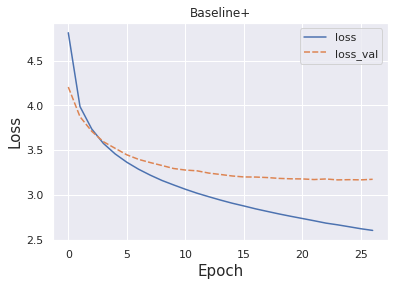

In [19]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd
sns.set() 

restore_latest_checkpoint = False

if restore_latest_checkpoint: 
    #add to existing losses 
    old_losses = pd.read_csv('loss.csv')[["epochs", "loss", "loss_val"]]
    start_index = old_losses.epochs.max() + 1
    new_data = [[start_index+i, losses[i][0], losses[i][1]] for i in range(len(losses))]
    new_losses = pd.DataFrame(new_data, columns = ["epochs", "loss", "loss_val"])
    loss_df = pd.concat([old_losses, new_losses], keys = ["epochs", "loss", "loss_val"]).reset_index(drop = True)
    
else:
    #create new df 
    loss_df = pd.DataFrame(losses, columns = ['loss', "loss_val"])
    loss_df = loss_df.reset_index().rename(columns= {'index': 'epochs'})
    
loss_df.to_csv("/content/drive/MyDrive/Colab Notebooks/sequences/sequences2/attention_loss.csv")

loss_df
p = sns.lineplot(data= loss_df.iloc[:, 1:])
p.set(title='Baseline+')
p.set_xlabel("Epoch", fontsize = 15)
p.set_ylabel("Loss", fontsize=15)